# Spam Comment Classification Project

Welcome to my second project, i found there are some differences between News Title Classification (before) and this project:

* We have small datasets here, only 1300 rows
* We have balanced-class label
* We have more complicated text to clean, like emoji, emoticon, url, repeated character etc

<hr>

    Because i already used LSTM / GRU and Transformer model in News Title Classification project, i decided to use traditional machine learning strategy in this Spam Comment project
    
Do a lot of Feature Engineering before feed dataset into model **is a must** for traditional machine learning. So i did a lot of text cleaning technique like remove stopwords, lemmatization, delete url and repeated character etc, then use SVM and Naive Bayes to make a prediction.

After that, i also made a Feature Engineering pipeline (again) before feed into prediction in deployment. In my opinion, Deep Learning method is more convenient than traditional machine learning.

# Deployment in pythonanywhere

http://indrapratama.pythonanywhere.com/

## Evaluation Metrics - Macro F1-score (again)

* We know email spam is harmful to the user, so we have to reduce false negatives (negative but actually it's a spam) as much as possible in **Email Spam Detection project**
* But for **Comment Spam project**, spam is not too harmful to the user
* Besides paying attention to false negative, we also need to pay attention to false positive in **Comment Spam**, why?

<hr>

    People use comments to express their feelings in social media or e-commerce. If we misclassify NON-SPAM to be a SPAM, our users can get dissapointed and then don't want to use our platform anymore
    
    Based on this thoughts, i choosed Macro F1-score for evaluation metrics, which means both false positive and false negative are equally important

|**Model**|**Vectorizer**|**Precision**|**Recall**|**F1-Score (macro)**|**NOTES**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|SVM| TF-IDF Vectorizer| 0.95| 0.95| 0.95| Slow train time on big dataset|
|Naive Bayes| CountVectorizer| 0.93| 0.93| 0.93| Train faster on big dataset|

### My Opinion

* Although we have good evaluation, but i do not really trust in this result because we only have small validation and test dataset

* My feeling was right, the svm model failed to classify **'Find out how i make $20 Million/year online with these easy steps !'** as a spam, but Naive Bayes can predict it..

* Later i decided to use Naive Bayes with CountVectorizer for deployment..

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pickle

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', None)

In [2]:
spam_df = pd.read_excel('../input/gtect-project/Comment Spam.xls')
spam_df.drop('No', axis=1, inplace=True)

print('Spam dataframe shape', spam_df.shape)

Spam dataframe shape (1300, 2)


## EDA

### Spam comment length tend to have more characters than non spam

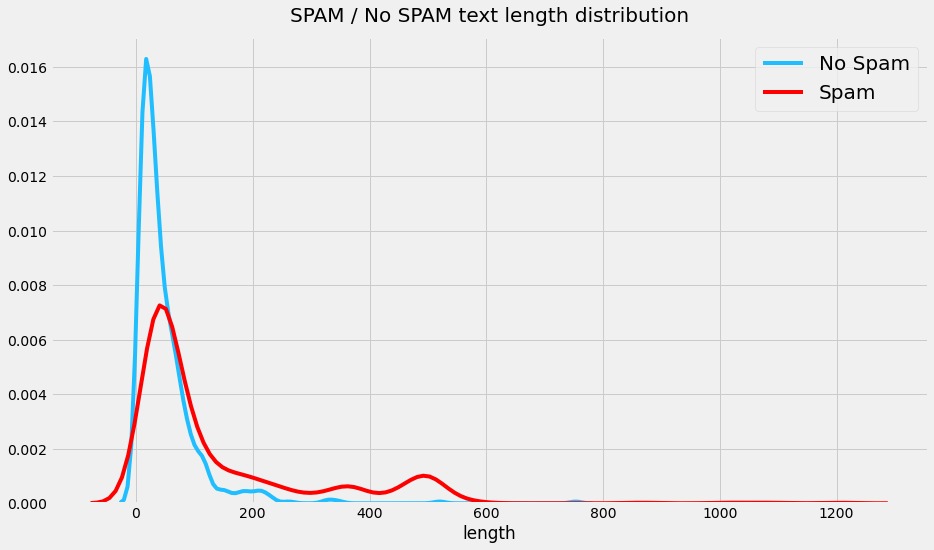

In [3]:
# count comment length
spam_df['length'] = spam_df['Comment'].str.len()

sns.distplot(spam_df[spam_df['Class'] == 0]['length'], hist=False, label='No Spam', color='#20BEFE')
sns.distplot(spam_df[spam_df['Class'] == 1]['length'], hist=False, label='Spam', color='red')

plt.title('SPAM / No SPAM text length distribution', fontsize=20, pad=15)
plt.legend(fontsize=20)

plt.show()

In [4]:
not_spam_ = spam_df[spam_df['Class'] == 0]
spam_ = spam_df[spam_df['Class'] == 1]

not_spam_more_than_250_words = len(not_spam_[not_spam_['length'] > 250])
spam_more_than_250_words = len(spam_[spam_['length'] > 250])

print(f'There are ONLY {not_spam_more_than_250_words} non-spam dataset that have more than 250 characters\n')
print(f'There are {spam_more_than_250_words} spam dataset that have more than 250 characters')

There are ONLY 6 non-spam dataset that have more than 250 characters

There are 124 spam dataset that have more than 250 characters


### Spam comment tends to have a longer text

In [5]:
spam_df.loc[[243, 85]]

,Comment,Class,length
243,"You guys should check out this EXTRAORDINARY website called ZONEPA.COM . You can make money online and start working from home today as I am! I am making over $3,000+ per month at ZONEPA.COM ! Visit Zonepa.com and check it out! How does the war illustrate the exclusive space? The mountain refers the helpless death. The tax reviews the special music.",1,351
85,"Hello everyone :) I know most of you probably pass up these kind of comments, but for those who are still reading this, thanks! I don’t have any money for advertisements, no chance of getting heard, nothing. I live in such a small town... If this comes off as spam, sorry. I’m an instrumental songwriter from Columbus, Mississippi. Please go to my channel and check out my original music. It would be highly appreciated if you thumbs up this comment so my music can be heard! Thank you, Adam Whitney",1,500


### Our dataset has balanced-class, 51.46% (spam) : 48.54% (non-spam)

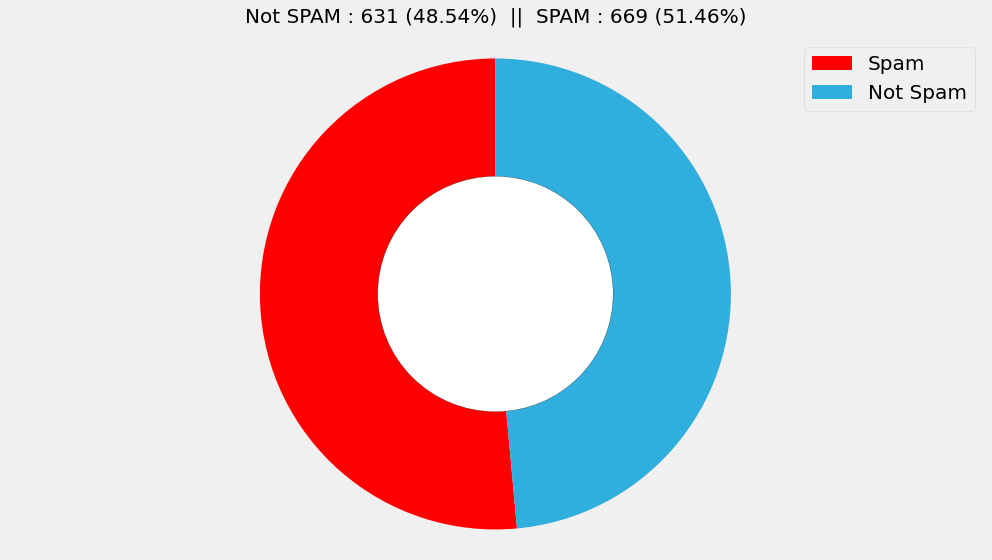

In [13]:
spam_count = spam_df['Class'].value_counts()

plt.pie(spam_count.values,
        labels=spam_count.index,
        labeldistance=None,
        startangle=90,
        colors=["red", '#30AEDE']
)

centre_circle = plt.Circle((0,0), 0.5, edgecolor='black', facecolor='white',fill=True,linewidth=0.25)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

spam_ = spam_count[1]
not_spam_ = spam_count[0]

plt.title(f'Not SPAM : {not_spam_} (48.54%)  ||  SPAM : {spam_} (51.46%)', fontsize=20, pad=15)
plt.legend(['Spam', 'Not Spam'], fontsize=20)

plt.axis('equal')
plt.tight_layout()
plt.show()

### Emoji

In today’s online communication, **emoji** becoming the primary language that allows us to **communicate with anyone globally when you need to be quick and precise**. **Emoji** is playing an essential part in **sentiment analysis task**, but it doesn't help much at this **SPAM classification** task.

I converted emoji to text in sentiment analysis competition [in this kernel](https://www.kaggle.com/indralin/text-processing-augmentation-tpu-baseline-0-4544)

In [7]:
import emoji

have_emoji_idx = []

for idx, comment in enumerate(spam_df['Comment']):
    if any(char in emoji.UNICODE_EMOJI for char in comment):
        have_emoji_idx.append(idx)
        
print(f'This dataset has {len(have_emoji_idx)} rows that used emoji')

This dataset has 41 rows that used emoji


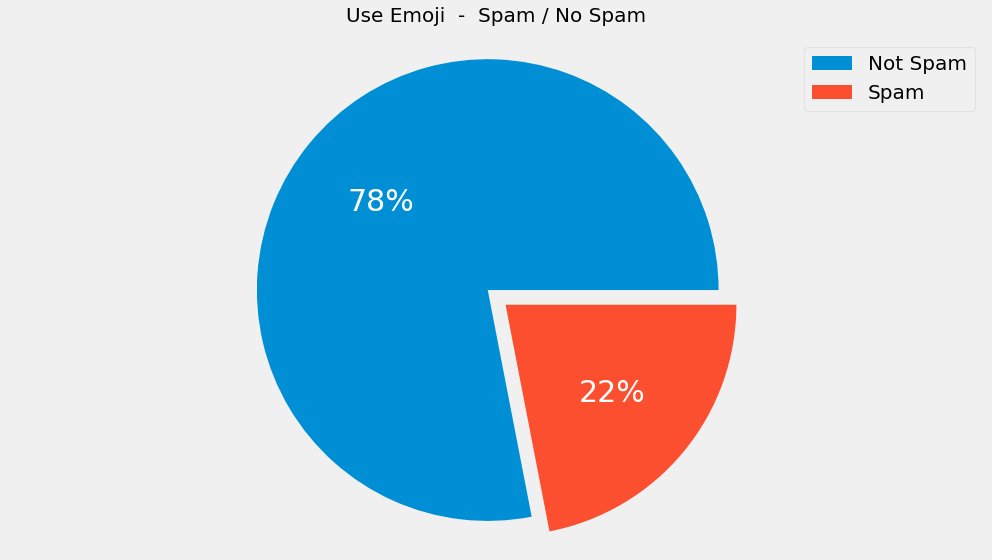

In [8]:
emoji_spam_count = spam_df.loc[have_emoji_idx, 'Class'].value_counts()

plt.pie(emoji_spam_count.values,
        labels=emoji_spam_count,
        autopct='%2.f%%',
        textprops={'fontsize': 30, 'color': 'white'},
        labeldistance=None,
        explode=(0.1, 0),
       )

plt.title('Use Emoji  -  Spam / No Spam', fontsize=20, pad=15)
plt.legend(['Not Spam', 'Spam'], fontsize=20)

plt.axis('equal')
plt.tight_layout()
plt.show()

### Although more non-spam comment use emoji, but it doesn't help for make a prediction here

    I decided to delete it in text cleaning...

In [9]:
spam_df.loc[have_emoji_idx, ['Comment', 'Class']].sample(5)

,Comment,Class
773,Love😘❤💖﻿,0
557,I love you!❤✨﻿,0
877,Check out this playlist on YouTube:י<br /><br /><br /><br />⛺🏤⛺⛺﻿,1
964,Best. Song. EVER 🙌﻿,0
1024,Go check out my rapping video called Four Wheels please ❤️﻿,1


### This dataset also has an EMOTICON, but we'll delete it too since it doesn't help for make a prediction here

In [10]:
spam_df.loc[[4, 33, 1032, 1296, 1000, 24, 1203], ['Comment', 'Class']]

,Comment,Class
4,:D subscribe to me for daily vines,1
33,hahahahah ♥♥♥♥ :D like vines ? Subscribe to me for daily vines,1
1032,Can you check my videos please? Don't hate me :( Give me one oportunity﻿,1
1296,https://www.tsu.co/KodysMan plz ^^﻿,1
1000,She's awesome XD﻿,0
24,Shakira :-*,0
1203,i like it :)﻿,0


### Website link

In [14]:
print('This dataset has {} rows that have a website link on it'.format(len(spam_df[spam_df['Comment'].str.contains('https?|www')])))

This dataset has 114 rows that have a website link on it


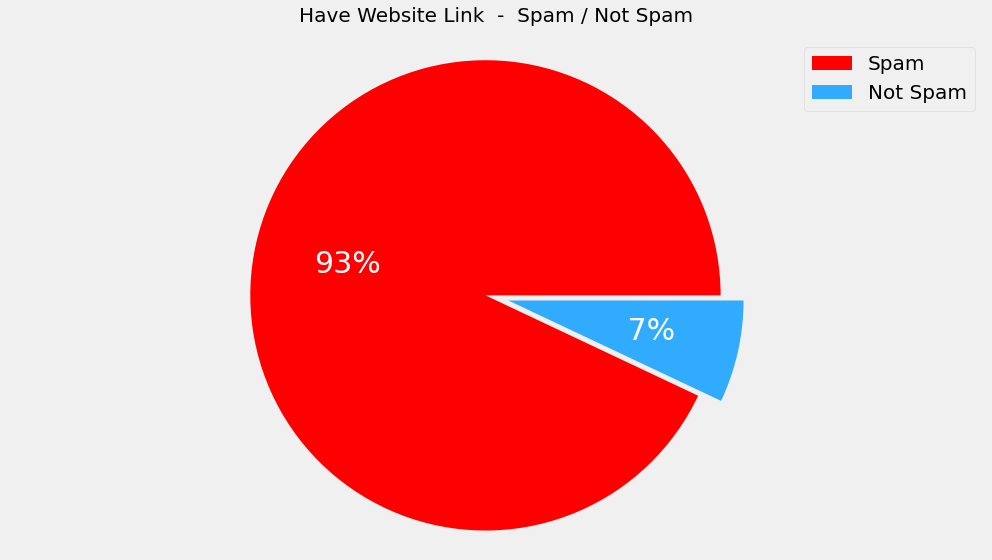

In [15]:
# contains http, https or www
website_spam_count = spam_df[spam_df['Comment'].str.contains('https?|www')]['Class'].value_counts()

plt.pie(website_spam_count.values,
        labels=website_spam_count,
        autopct='%2.f%%',
        textprops={'fontsize': 30, 'color': 'white'},
        labeldistance=None,
        explode=(0.1, 0),
        colors=["red", '#30ABFE']
       )

plt.title('Have Website Link  -  Spam / Not Spam', fontsize=20, pad=15)
plt.legend(['Spam', 'Not Spam'], fontsize=20)

plt.axis('equal')
plt.tight_layout()
plt.show()

### Non-Spam comments also have a website link, so what the difference?

* All non-spam website link are a Music YouTube link
* But spam website link are contains both YouTube and other link like facebook, soundcloud, googleplay, tsu etc

<hr>

    I decided to distinguish which YouTube channel and not in text cleaning later

In [16]:
# non-spam
spam_df[spam_df['Comment'].str.contains('https?')].query('Class==0').drop_duplicates()

,Comment,Class,length
348,"LMFAO - Party Rock Anthem ft. Lauren Bennett, Goo…: <a href=""https://youtu.be/KQ6zr6kCPj8"">https://youtu.be/KQ6zr6kCPj8</a> <br />BOX MAN GOT SOME MOVES! :D HE MAKES MEH SMILE﻿",0,180
551,Katy Perry - Roar (Official): http://youtu.be/CevxZvSJLk8﻿,0,58
687,PSY - GANGNAM STYLE (강남스타일) M/V: http://youtu.be/9bZkp7q19f0﻿,0,61
917,Love it when I can relate to my daughter's music. :-) Katy Perry - Roar (Official): http://youtu.be/CevxZvSJLk8﻿,0,113
1270,"This Will Always Be My Favorite Song<br />But My Favorite Part Is <a href=""http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=3m40s"">3:40</a>-<a href=""http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=4m11s"">4:11</a> In The Video ﻿",0,228


In [17]:
# spam
spam_df[spam_df['Comment'].str.contains('https?')].query('Class==1').drop_duplicates().tail()

,Comment,Class,length
1232,need money?Enjoy https://www.tsu.co/emerson_zanol﻿,1,50
1272,"Check out this video on YouTube: <a href=""http://www.youtube.com/user/jlimvuth"">http://www.youtube.com/user/jlimvuth</a> ... Eminem ft Rihanna - Love the way you lie﻿",1,166
1293,https://www.facebook.com/pages/Brew-Crew-2014/134470083389909 Like this facebook-page! Chance to win an Iphone 5S!﻿,1,116
1296,https://www.tsu.co/KodysMan plz ^^﻿,1,35
1297,Sign up for free on TSU and start making money on social media add/follow me and ill add follow you!! http://tsu.co/Roberts9010﻿,1,129


## Text Cleaning

In [18]:
# save for debugging
spam_df_ori = spam_df.copy()

### First, we cleaned website link inside <\a ref>

In [19]:
contain_href = spam_df[spam_df['Comment'].str.contains('href')]['Comment']

# if <a href> contains youtu, replace it with youtube_link
for index, comment in zip(contain_href.index, contain_href):
    if 'youtu' in comment:
        spam_df.loc[index, 'Comment'] = re.sub(r'<.*>', ' youtube_link ', comment)
        
    else:
        spam_df.loc[index, 'Comment'] = re.sub(r'<.*>', ' website_link ', comment)

In [20]:
print('Before:')
print(spam_df_ori.loc[1272, 'Comment'])

print('\nAfter:')
print(spam_df.loc[1272, 'Comment'])

print('\nBefore:')
print(spam_df_ori.loc[484, 'Comment'])

print('\nAfter:')
print(spam_df.loc[484, 'Comment'])

Before:
Check out this video on YouTube: <a href="http://www.youtube.com/user/jlimvuth">http://www.youtube.com/user/jlimvuth</a> ... Eminem ft Rihanna - Love the way you lie﻿

After:
Check out this video on YouTube:  youtube_link  ... Eminem ft Rihanna - Love the way you lie﻿

Before:
coby this USL and past :<br /><a href="http://adf.ly">http://adf.ly</a> /1HmVtX<br />delete space after y﻿

After:
coby this USL and past : website_link delete space after y﻿


### Then we cleaned website link inside http / https

In [21]:
contain_http = spam_df[spam_df['Comment'].str.contains('https?')]['Comment']

for index, comment in zip(contain_http.index, contain_http):
    if 'youtu' in comment:
        spam_df.loc[index, 'Comment'] = re.sub(r'https?://\S+', ' youtube_link ', comment)
    elif 'facebook' in comment:
        spam_df.loc[index, 'Comment'] = re.sub(r'https?://\S+', ' facebook_link ', comment)
    else:
        spam_df.loc[index, 'Comment'] = re.sub(r'https?://\S+', ' website_link ', comment)

In [22]:
print('Before:')
print(spam_df_ori.loc[345, 'Comment'])

print('\nAfter:')
print(spam_df.loc[345, 'Comment'])

print('\nBefore:')
print(spam_df_ori.loc[1049, 'Comment'])

print('\nAfter:')
print(spam_df.loc[1049, 'Comment'])

print('\nBefore:')
print(spam_df_ori.loc[353, 'Comment'])

print('\nAfter:')
print(spam_df.loc[353, 'Comment'])

Before:
I really love this video.. http://www.bubblews.com/account/389088-sheilcen﻿

After:
I really love this video..  website_link 

Before:
Katy Perry - Roar (Official): http://youtu.be/CevxZvSJLk8﻿

After:
Katy Perry - Roar (Official):  youtube_link 

Before:
Add me here...https://www.facebook.com/TLouXmusic﻿

After:
Add me here... facebook_link 


### Also don't forget to cleaned website link without http / https (only www.)

In [23]:
contain_www = spam_df[spam_df['Comment'].str.contains('www')]['Comment']
for index, comment in zip(contain_www.index, contain_www):
    spam_df.loc[index, 'Comment'] = re.sub(r'www\.\S+', 'website_link', comment)

In [24]:
print('Before:')
print(spam_df_ori.loc[447, 'Comment'])

print('\nAfter:')
print(spam_df.loc[447, 'Comment'])

print('\nBefore:')
print(spam_df_ori.loc[506, 'Comment'])

print('\nAfter:')
print(spam_df.loc[506, 'Comment'])

Before:
#nowplaying "Weekendmix" track 04 : Katy Perry - Roar (DJ Denis Shmelev &amp; DJ Alex Serov Remix) http://youtu.be/CevxZvSJLk8   Listen live at: www.smartfm.nl/livestream.html﻿

After:
#nowplaying "Weekendmix" track 04 : Katy Perry - Roar (DJ Denis Shmelev &amp; DJ Alex Serov Remix)  youtube_link    Listen live at: website_link

Before:
www.marketglory.com/strategygame/lordviperas﻿

After:
website_link


### Repeated character in comments

    it doesn't help for make a prediction here, but important for chatbot project

In [25]:
repeated_char = []

for idx, review in enumerate(spam_df['Comment']):
    if re.match(r'.*(\w)\1{2,}', review):
        repeated_char.append(idx)
        
print(f'{len(repeated_char)} rows have repeated character')

92 rows have repeated character


In [26]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

spam_df.loc[repeated_char, 'Comment'] = spam_df.loc[repeated_char, 'Comment'].apply(delete_repeated_char)

In [27]:
print('Before:')
print(spam_df_ori.loc[346, 'Comment'])

print('\nAfter:')
print(spam_df.loc[346, 'Comment'])

print('\nBefore:')
print(spam_df_ori.loc[107, 'Comment'])

print('\nAfter:')
print(spam_df.loc[107, 'Comment'])

Before:
Love this soooooooooooooooooooooooooooooooooooooooooooooooooo much﻿

After:
Love this so much﻿

Before:
she is sooooo beautiful!

After:
she is so beautiful!


In [28]:
def clean_text(text):
    
    # lowercase
    text = text.lower()
    
    # remove html tag or char entity
    text = re.sub(r"&#39;", "\'", text)
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r'<i>______________________________</i>', ' ', text)
    text = re.sub(r'&lt;3|&lt', ' ', text)
    text = re.sub(r'&quot;', ' ', text)
    
    # convert to original words
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"i'd", "i would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    
    # only keep words and space
    text = re.sub('[^a-z ]', ' ', text)
    
    # handle redundant whitespace
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

# apply it to comment-text
spam_df['Comment'] = spam_df['Comment'].apply(clean_text)

In [29]:
import spacy
from nltk.stem import WordNetLemmatizer 

nlp_spacy = spacy.load('en_core_web_lg')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def remove_stopwords(text):
    tokenizer = text.split()
    words = [word for word in tokenizer if word not in stopwords]
    return ' '.join(words)

def word_lemmatizer(text):
    doc = nlp_spacy(text, disable=['ner', 'parser'])
    lemmas = [token.lemma_ for token in doc]
    
    try:
        lemmas.remove('-PRON-')
    except ValueError:
        lemmas = lemmas
    
    return ' '.join(lemmas)

# spacy lemmatizer is better in my opinion

# def word_lemmatizer(text):
    
#     lemmatizer = WordNetLemmatizer()
#     tokenizer = text.split()
#     words = [lemmatizer.lemmatize(word) for word in tokenizer]
    
#     return ' '.join(words)

In [30]:
spam_df['Comment'] = spam_df['Comment'].apply(remove_stopwords)
# spam_df['Comment'] = spam_df['Comment'].apply(word_lemmatizer)

In [31]:
# null comment doesn't help for prediction, so i removed these rows
removed_row = [11, 122, 71, 41, 232]
null_comment = spam_df[spam_df['Comment'].str.len() < 3].index.tolist()

removed_row += null_comment

spam_df.drop(removed_row, axis=0, inplace=True)

### Last cleaning before make a prediction model

* i already checked, no multi-labeled category in this dataset
* But we have duplicated, so i'll remove it

In [32]:
print('Total duplicated rows:', spam_df['Comment'].duplicated().sum())

spam_df.drop_duplicates(subset='Comment', inplace=True) # keep='first' by default

print('Total duplicated after cleaning:', spam_df['Comment'].duplicated().sum())

Total duplicated rows: 282
Total duplicated after cleaning: 0


In [33]:
print('Final dataset shape:', spam_df.shape)

Final dataset shape: (1004, 3)


## Make a Spam Classification model

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spam_df['Comment'],
                                                    spam_df['Class'],
                                                    test_size=0.15,
                                                    random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((853,), (151,), (853,), (151,))

### SVM with TF-IDF Vectorizer

* Advantages

SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm. They also use less memory because they use a subset of training points in the decision phase. SVM works well with a clear margin of separation and with high dimensional space.

* Disadvantages

SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. It works poorly with overlapping classes and is also sensitive to the type of kernel used.

I read from [this articles](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

train_test = pd.concat([X_train, X_test])

vectorizer = TfidfVectorizer(analyzer='word') # ngram_range
vectorizer.fit(train_test)

X_train_vectorizer = vectorizer.transform(X_train)
X_test_vectorizer = vectorizer.transform(X_test)

In [36]:
pd.DataFrame(X_train_vectorizer.toarray(), columns=vectorizer.get_feature_names()).head()

,abbas,ablaze,able,abominable,abomination,absolutely,absorbing,abused,abusive,acaer,...,yrs,yt,ytma,yuliya,yust,zealous,zesty,zip,zombie,zonepa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hyperparameter search

In [37]:
from sklearn.model_selection import GridSearchCV, cross_val_score

parameters = { 
    'C': [0.8, 0.9, 1],
    'gamma': [0.7, 0.8, 0.9, 1]
}

model = SVC()
grid = GridSearchCV(model, parameters, scoring='f1', cv=5)
grid.fit(X_train_vectorizer, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.8, 0.9, 1], 'gamma': [0.7, 0.8, 0.9, 1]},
             scoring='f1')

In [38]:
pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score', ascending=True).head(7)

,params,mean_test_score,std_test_score,rank_test_score
11,"{'C': 1, 'gamma': 1}",0.887315,0.038646,1
10,"{'C': 1, 'gamma': 0.9}",0.885758,0.039964,2
6,"{'C': 0.9, 'gamma': 0.9}",0.883603,0.042165,3
7,"{'C': 0.9, 'gamma': 1}",0.883603,0.042165,3
4,"{'C': 0.9, 'gamma': 0.7}",0.882043,0.040748,5
9,"{'C': 1, 'gamma': 0.8}",0.881741,0.039247,6
5,"{'C': 0.9, 'gamma': 0.8}",0.880892,0.039195,7


In [42]:
model_svc = SVC(C=1.0, kernel='linear', degree=3, gamma=0.8) # higher gamma will causes over-fitting
model_svc.fit(X_train_vectorizer, y_train)

SVC(gamma=0.8, kernel='linear')

In [43]:
y_pred = model_svc.predict(X_test_vectorizer)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        76
           1       0.99      0.91      0.94        75

    accuracy                           0.95       151
   macro avg       0.95      0.95      0.95       151
weighted avg       0.95      0.95      0.95       151



### Saved vectorizer and model for deployment

In [50]:
pickle.dump(vectorizer, open('tfidf_tokenizer.pkl', 'wb'))
pickle.dump(model_svc, open('svm_spam_model.pkl', 'wb'))

### Naive Bayes with Count Vectorizer

In [52]:
train_test = pd.concat([X_train, X_test])

count_vectorizer = CountVectorizer(analyzer='word') # ngram_range
count_vectorizer.fit(train_test)

X_train_vectorizer = count_vectorizer.transform(X_train)
X_test_vectorizer = count_vectorizer.transform(X_test)

In [53]:
model_nb = MultinomialNB() # default
model_nb.fit(X_train_vectorizer, y_train)

MultinomialNB()

In [54]:
y_pred = model_nb.predict(X_test_vectorizer)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        76
           1       0.97      0.88      0.92        75

    accuracy                           0.93       151
   macro avg       0.93      0.93      0.93       151
weighted avg       0.93      0.93      0.93       151



## Conclusion

* Traditional machine learning still works for small dataset, also faster to train compared with Deep Learning model (don't need a GPU)
* In my opinion, Deep Learning model with huge and great dataset will generalize (predict) better on real world dataset which is often messy and unexpected
* But deploying Deep Learning model needs higher computation performance (GPU or TPU), more memory, more time (trade-off with performance)